In [18]:
import torch
from statistics import mean

from tqdm import tqdm
from pathlib import Path
import jsonlines
from transformers import BertModel, BertTokenizerFast, PreTrainedTokenizerFast


ROOT = Path("../data/")

MAX_LENGTH = 256

LABELS = [
    "Appeal_to_Values",
    "Loaded_Language",
    "Consequential_Oversimplification",
    "Causal_Oversimplification",
    "Questioning_the_Reputation",
    "Straw_Man",
    "Repetition",
    "Guilt_by_Association",
    "Appeal_to_Hypocrisy",
    "Conversation_Killer",
    "False_Dilemma-No_Choice",
    "Whataboutism",
    "Slogans",
    "Obfuscation-Vagueness-Confusion",
    "Name_Calling-Labeling",
    "Flag_Waving",
    "Doubt",
    "Appeal_to_Fear-Prejudice",
    "Exaggeration-Minimisation",
    "Red_Herring",
    "Appeal_to_Popularity",
    "Appeal_to_Authority",
    "Appeal_to_Time",
]

MODEL_NAME = "bert-base-multilingual-cased"
tokenizer = BertTokenizerFast.from_pretrained(MODEL_NAME)


def parse_text(text, span_objs, tokenizer: PreTrainedTokenizerFast, labels):
    assert isinstance(
        tokenizer, PreTrainedTokenizerFast
    ), "Must be a sub-class of PreTrainedTokenizerFast"

    encoding = tokenizer(
        text,
        return_offsets_mapping=True,
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH,
    )

    label_encoding = [
        [
            0,
        ]
        * len(encoding.tokens())
        for _ in labels
    ]

    for span in span_objs:
        label_start, label_end, label = span["start"], span["end"], span["technique"]
        # l is for sequence number
        for l, (token_start, token_end) in enumerate(encoding.offset_mapping):
            if is_inside(token_start, token_end, label_start, label_end):
                label_encoding[labels.index(label)][l] = 1

    return encoding, label_encoding


def is_inside(token_start, token_end, label_start, label_end):
    return token_start >= label_start and token_end <= label_end


def find_consecutive_trues(flags):
    """
    This function takes an array of boolean flags and returns a list of ranges
    of all consecutive true values.

    Args:
        flags: A list of boolean flags.

    Returns:
        A list of tuples, where each tuple represents a range of consecutive
        true values. The tuple contains the starting and ending indices (inclusive)
        of the range.
    """
    ranges = []
    start_idx = None
    for i, flag in enumerate(flags):
        if flag and start_idx is None:
            start_idx = i
        elif not flag and start_idx is not None:
            ranges.append((start_idx, i - 1))
            start_idx = None
    if start_idx is not None:
        ranges.append((start_idx, len(flags) - 1))
    return ranges


# Example usage
# flags = [1, 1, 0, 0, 1, 1, 1]
# ranges = find_consecutive_trues(flags)
# print(ranges)  # Output: [(0, 1), (3, 5)]



def find_consecutive_trues(flags):
    """
    This function takes an array of boolean flags and returns a list of ranges
    of all consecutive true values.

    Args:
        flags: A list of boolean flags.

    Returns:
        A list of tuples, where each tuple represents a range of consecutive
        true values. The tuple contains the starting and ending indices (inclusive)
        of the range.
    """
    ranges = []
    start_idx = None
    for i, flag in enumerate(flags):
        if flag and start_idx is None:
            start_idx = i
        elif not flag and start_idx is not None:
            ranges.append((start_idx, i - 1))
            start_idx = None
    if start_idx is not None:
        ranges.append((start_idx, len(flags) - 1))
    return ranges


def parse_sample(sample):
    encoding, label_encoding = parse_text(
        sample["text"], sample["labels"], tokenizer, LABELS
    )
    
    return {"encoding": encoding, 'id': sample['id'], **encoding, "labels": label_encoding}

# Model

In [48]:
from transformers import BertForTokenClassification
from torch import nn
import torch.nn.functional as F

import torch
from statistics import mean

from tqdm import tqdm
from pathlib import Path
import jsonlines
from transformers import BertModel, BertTokenizerFast, PreTrainedTokenizerFast

label2id = {label: id for id, label in enumerate(LABELS)}
id2label = {id: label for id, label in enumerate(LABELS)}

from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import BertPreTrainedModel, BertModel
from transformers.utils import (
    add_code_sample_docstrings,
    add_start_docstrings,
    add_start_docstrings_to_model_forward,
    logging,
    replace_return_docstrings,
)

from typing import Optional, Union, Tuple
from transformers.modeling_outputs import TokenClassifierOutput


class CustomBertForTokenClassification(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels

        self.bert = BertModel(config, add_pooling_layer=False)
        classifier_dropout = (
            config.classifier_dropout
            if config.classifier_dropout is not None
            else config.hidden_dropout_prob
        )
        self.dropout = nn.Dropout(classifier_dropout)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

        # Initialize weights and apply final processing
        self.post_init()

    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple[torch.Tensor], TokenClassifierOutput]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size, sequence_length)`, *optional*):
            Labels for computing the token classification loss. Indices should be in `[0, ..., config.num_labels - 1]`.
        """
        return_dict = (
            return_dict if return_dict is not None else self.config.use_return_dict
        )

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]

        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)

        loss = None
        if labels is not None:
            loss_fct = nn.BCEWithLogitsLoss(reduction='none')
            loss = loss_fct(logits, labels.transpose(1, 2).float())
            loss = (loss * attention_mask.unsqueeze(dim=2)).mean()

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return TokenClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


In [43]:
batch['tensors']['attention_mask'].shape

torch.Size([3, 256])

In [20]:
import torch
import jsonlines
from pathlib import Path

from transformers import DataCollatorWithPadding, TrainingArguments, Trainer


In [21]:
ROOT = Path(ROOT)
TRAIN_FILE = ROOT / "araieval24_task1_train.jsonl"
DEV_FILE = ROOT / "araieval24_task1_dev.jsonl"

print(f"Training on {TRAIN_FILE.absolute()}\nValidating on {DEV_FILE.absolute()}\n")

with jsonlines.open(TRAIN_FILE) as jsonfile:
    for obj in jsonfile:
        print(obj)

        parsed = parse_sample(obj)
        print(parsed.keys())
        break

Training on /home/riyadh/codes/nlp/araieval_arabicnlp24/task1/src/../data/araieval24_task1_train.jsonl
Validating on /home/riyadh/codes/nlp/araieval_arabicnlp24/task1/src/../data/araieval24_task1_dev.jsonl

{'id': '7365', 'text': 'تحذيرات من حرب جديدة في حال فشل الانتخابات القادمة', 'labels': [{'start': 0, 'end': 50, 'technique': 'Appeal_to_Fear-Prejudice', 'text': 'تحذيرات من حرب جديدة في حال فشل الانتخابات القادمة'}, {'start': 11, 'end': 14, 'technique': 'Loaded_Language', 'text': 'حرب'}], 'type': 'tweet'}
dict_keys(['encoding', 'id', 'input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'labels'])


In [22]:
import json
from torch.utils.data import Dataset, DataLoader


class DatasetFromJson(Dataset):
    def __init__(self, data_path):
        """
        Args:
          data_path (str): Path to the JSONLines file containing map style data.
        """
        self.data_path = data_path
        self.encodings = []
        self.tensors = []
        self.raw = []
        self._load_data()

    def _load_data(self):
        """
        Loads map style data from the JSONLines file.
        """
        with open(self.data_path, "r") as f:
            for line in f:
                data = json.loads(line.strip())
                if 'labels' not in data:
                    data['labels'] = []
                    
                sample = parse_sample(data)
                self.encodings.append(sample["encoding"])

                del sample["encoding"], sample["id"]
                
                self.tensors.append(sample)
                self.raw.append(data)

    def __len__(self):
        """
        Returns the number of samples in the dataset.
        """
        return len(self.raw)

    def __getitem__(self, idx):
        """
        Retrieves a sample from the dataset.

        Args:
          idx (int): Index of the sample to retrieve.

        Returns:
          dict: A dictionary containing the map style features.
        """
        return self.tensors[idx], self.encodings[idx], self.raw[idx]


In [23]:
train_ds = DatasetFromJson(TRAIN_FILE)
val_ds = DatasetFromJson(DEV_FILE)

In [24]:
from typing import List


class CollateFn:
    def __init__(self, return_raw=False):
        self.data_collator = DataCollatorWithPadding(tokenizer, padding=True)
        self.return_raw = return_raw
        
    def __call__(self, data: List):
        # 'encoding', 'input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'labels'
        encodings = []
        raws = []
        tensors = []
        
        for tensor, encoding, raw in data:
            encodings.append(encoding)
            raws.append(raw)
            tensors.append(tensor)

        batch = self.data_collator(tensors)
        
        return {
            'tensors': batch,
            'encodings': encodings,
            'raws': raws
        }
        

In [25]:
collate_fn = CollateFn()
train_dl = DataLoader(train_ds, batch_size=3, collate_fn = collate_fn)
val_dl = DataLoader(val_ds, batch_size=3, collate_fn=CollateFn(return_raw=True))

batch = next(iter(val_dl))

In [26]:
from typing import Dict
import sys

sys.path.append("../../task1")

from scorer import task1 as t1scorer
from collections import defaultdict

In [27]:
def format_for_output(objs):
    labels_per_par = defaultdict(list)
    for obj in objs:
        par_id = obj["id"]
        labels = obj["labels"]
        labels_per_par[par_id] = t1scorer.process_labels(labels)
    return labels_per_par


In [28]:
def parse_label_encoding(text, encoding, label_encoding, labels):
    label_encoding = label_encoding > 0
    span_objs = []
    word_ids = encoding.word_ids()
    for i, label in enumerate(labels):
        flags = label_encoding[i]
        span_ranges = find_consecutive_trues(flags)
        for start_idx, end_idx in span_ranges:
            start_word_id, end_word_id = word_ids[start_idx], word_ids[end_idx]
            
            if start_word_id is None or end_word_id is None:
                # skip padding
                continue
                
            (start_char_idx, _), (_, end_char_idx) = encoding.word_to_chars(
                start_word_id
            ), encoding.word_to_chars(end_word_id)

            span_text=""
            if text is not None:
                span_text = text[start_char_idx: end_char_idx]

            obj = {
                "technique": label,
                "start": start_char_idx,
                "end": end_char_idx,
                "text": span_text,
            }

            span_objs.append(obj)
    return span_objs


In [29]:
def compute_metrics(batch, logits):
    gold = format_for_output(batch['raws'])
    hypotheses: List[Dict] = []
    logits = logits.transpose(1, 2)
    assert logits.size(1) == len(LABELS), "expects the label in dim=1"
    
    for i in range(logits.size(0)):
        hypothesis = parse_label_encoding(None, batch['encodings'][i], logits[i], LABELS)
        hypotheses.append({
            "id": batch['raws'][i]['id'],
            "labels": hypothesis
        })
        
    hypotheses = format_for_output(hypotheses)
    
    res_for_screen, f1, f1_per_label = t1scorer.FLC_score_to_string(gold, hypotheses, per_label=True)
    
    metrics = {
        'f1': f1,
        **f1_per_label
    }
    
    return metrics

In [30]:
THRESHOLD = 0
logits = torch.randn((3, MAX_LENGTH, len(LABELS)))
logits = logits > THRESHOLD
compute_metrics(batch, logits)

{'f1': 0.040144364613763237,
 'Appeal_to_Values': 0,
 'Loaded_Language': 0.34234234234234234,
 'Consequential_Oversimplification': 0,
 'Causal_Oversimplification': 0,
 'Questioning_the_Reputation': 0,
 'Straw_Man': 0,
 'Repetition': 0,
 'Guilt_by_Association': 0,
 'Appeal_to_Hypocrisy': 0,
 'Conversation_Killer': 0,
 'False_Dilemma-No_Choice': 0,
 'Whataboutism': 0,
 'Slogans': 0,
 'Obfuscation-Vagueness-Confusion': 0,
 'Name_Calling-Labeling': 0.31144465290806755,
 'Flag_Waving': 0,
 'Doubt': 0.18181818181818182,
 'Appeal_to_Fear-Prejudice': 0,
 'Exaggeration-Minimisation': 0,
 'Red_Herring': 0,
 'Appeal_to_Popularity': 0,
 'Appeal_to_Authority': 0,
 'Appeal_to_Time': 0}

In [31]:
batch['tensors'].keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'labels'])

In [32]:
import os
from pathlib import Path
from statistics import mean
from typing import List

import torch
from torch import nn
from torch.utils.data import Dataset
from tqdm import tqdm
from transformers.modeling_outputs import TokenClassifierOutput

import logging

logging.basicConfig(format="%(asctime)s %(message)s", level=logging.INFO)
logger = logging.getLogger(__name__)

device = "cuda" if torch.cuda.is_available() else "cpu"


def save_checkpoint(model, optimizer, epoch, checkpoint_dir):
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    path = Path(checkpoint_dir) / "model_best.pt"

    torch.save(
        {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict()
        },
        path,
    )


def validation(model, valid_dl, max_step):
    model.eval()
    loss_across_batches = []
    metric_across_batches = dict(zip(['f1', ] + LABELS, [0.0, ] * 24))

    with torch.no_grad():
        bar = tqdm(valid_dl, leave=False)
        for step_no, batch in enumerate(bar):
            for key in batch['tensors'].keys():
                batch['tensors'][key] = batch['tensors'][key].to(device)
            
            # calculate loss on valid
            loss, logits = step(model, batch['tensors'])
            loss_across_batches.append(loss.item())

            metrics = compute_metrics(batch, logits)
            # sum up
            for k, v in metrics.items():
                metric_across_batches[k] += v

            if step_no == max_step:
                break

        bar.close()

        # we need the mean
        for k,v in metric_across_batches.items():
            metric_across_batches[k] /= (step_no + 1)

    return {"loss": mean(loss_across_batches), **metric_across_batches}


def step(model, batch):
    output: TokenClassifierOutput = model(input_ids=batch['input_ids'],
                                          token_type_ids=batch['token_type_ids'],
                                          attention_mask=batch['attention_mask'],
                                          labels=batch['labels'] if 'labels' in batch else None)
    
    return output['loss'] if 'loss' in output else None, output['logits']


def fit(
    model: nn.Module,
    optimizer,
    train_dl: torch.utils.data.DataLoader,
    valid_dl: torch.utils.data.DataLoader,
    config: dict,
    args,
    lr_scheduler=None,
    checkpoint_dir="./checkpoint",
    max_step=-1,
    experiment_name=None,
    epoch=0,
):

    best_f1 = float("-inf")

    _training_history = {
        "train/loss": [],
        "valid/loss": [],
        "valid/f1": []
    }
    _validation_history = {f"valid/{k}" :[] for k in LABELS}
    history = {**_training_history, **_validation_history}

    for epoch in range(epoch + 1, epoch + config["max_epoch"] + 1):
        model.train()
        loss_across_batches = []
        bar = tqdm(train_dl, unit="batch")

        for step_no, batch in enumerate(bar):
            # move to gpu
            for key in batch['tensors'].keys():
                batch['tensors'][key] = batch['tensors'][key].to(device)
        
            # reset grads
            optimizer.zero_grad()

            # step forward
            loss, logits = step(model, batch['tensors'])

            # step backward
            loss.backward()

            optimizer.step()

            loss_across_batches.append(loss.item())

            # show each batch loss in tqdm bar
            bar.set_postfix(**{"loss": loss.item()})
        
            # skip training on the entire training dataset
            # useful during debugging
            if step_no == max_step:
                break

        validation_metrics = validation(model, valid_dl, max_step)

        history["train/loss"].append(mean(loss_across_batches))
        for k, v in validation_metrics.items():
            history[f"valid/{k}"].append(v)
        

        if validation_metrics["f1"] > best_f1:
            best_f1 = validation_metrics["f1"]
            save_checkpoint(model, optimizer, epoch, checkpoint_dir)
            print("🎉 best f1 reached, saved a checkpoint.")

        log(epoch, history)

    return history



def log(epoch, history):
    print(
        f"Epoch: {epoch},\tTrain Loss: {history['train/loss'][-1]},\tVal Loss: {history['valid/loss'][-1]}\tVal F1: {history['valid/f1'][-1]}"
    )


def load_checkpoint(model, checkpoint_path, optimizer=None, lr_scheduler=None):
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=torch.device(device))
        model.load_state_dict(checkpoint["model_state_dict"])

        if optimizer:
            optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        if lr_scheduler:
            lr_scheduler.load_state_dict(checkpoint["lr_scheduler_state_dict"])
        epoch = checkpoint["epoch"]

        logger.info(f"🎉 Loaded existing model. Epoch: {checkpoint['epoch']}")
        return model, optimizer, lr_scheduler, epoch

    else:
        raise Exception("No checkpoint found in the provided path")



# Train

In [33]:
def model_init():
    # For reproducibility
    return CustomBertForTokenClassification.from_pretrained(MODEL_NAME, id2label=id2label, label2id=label2id)

In [49]:
model = model_init()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
config = {
    'max_epoch': 2,
}
fit(model_init(), optimizer, train_dl, val_dl, config, None, max_step=2)

Some weights of CustomBertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of CustomBertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|                                                                                                        | 0/2333 [00:00<?, ?batch/s]


RuntimeError: The size of tensor a (23) must match the size of tensor b (256) at non-singleton dimension 2

In [35]:
def generate(model, tokenizer, text):
    model.eval()

    with torch.no_grad():
        encoding = tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=MAX_LENGTH,
            return_tensors="pt"
        )
        
        # calculate loss on valid
        _, logits = step(model, encoding)
        logits = logits[0].transpose(0,1)
        
        # returns a list of span
        hypothesis = parse_label_encoding(text, encoding, logits, LABELS)
    return hypothesis

In [36]:
generate(model, tokenizer, "تحذيرات من حرب جديدة في حال فشل الانتخابات القادمة")

[{'technique': 'Appeal_to_Values',
  'start': 0,
  'end': 50,
  'text': 'تحذيرات من حرب جديدة في حال فشل الانتخابات القادمة'},
 {'technique': 'Loaded_Language', 'start': 0, 'end': 7, 'text': 'تحذيرات'},
 {'technique': 'Loaded_Language', 'start': 21, 'end': 23, 'text': 'في'},
 {'technique': 'Loaded_Language', 'start': 28, 'end': 31, 'text': 'فشل'},
 {'technique': 'Consequential_Oversimplification',
  'start': 0,
  'end': 7,
  'text': 'تحذيرات'},
 {'technique': 'Consequential_Oversimplification',
  'start': 0,
  'end': 7,
  'text': 'تحذيرات'},
 {'technique': 'Consequential_Oversimplification',
  'start': 8,
  'end': 10,
  'text': 'من'},
 {'technique': 'Consequential_Oversimplification',
  'start': 43,
  'end': 50,
  'text': 'القادمة'},
 {'technique': 'Consequential_Oversimplification',
  'start': 43,
  'end': 50,
  'text': 'القادمة'},
 {'technique': 'Causal_Oversimplification',
  'start': 0,
  'end': 7,
  'text': 'تحذيرات'},
 {'technique': 'Causal_Oversimplification',
  'start': 28,
  'e

In [37]:
def evaluate(filepath, model, tokenizer):
    """
    takes a filepath and saves output following the shared task's format and metrics if labels are available
    """
    infile = jsonlines.open(filepath)
    outpath = filepath + ".hyp"
    outfile = open(outpath, 'w', encoding="utf-8")

    for sample in tqdm(infile):
        hypothesis = generate(model, tokenizer, sample['text'])
        outfile.write(json.dumps({'id': sample['id'], 'labels': hypothesis}, ensure_ascii=False) + "\n")
    infile.close()
    outfile.close()
    
    print('🎉 output saved to', outpath)


testfile = "../data/dummytest.jsonl"
evaluate(testfile, model, tokenizer)

11it [00:03,  3.21it/s]

🎉 output saved to ../data/dummytest.jsonl.hyp


In [38]:
import matplotlib.pyplot as plt

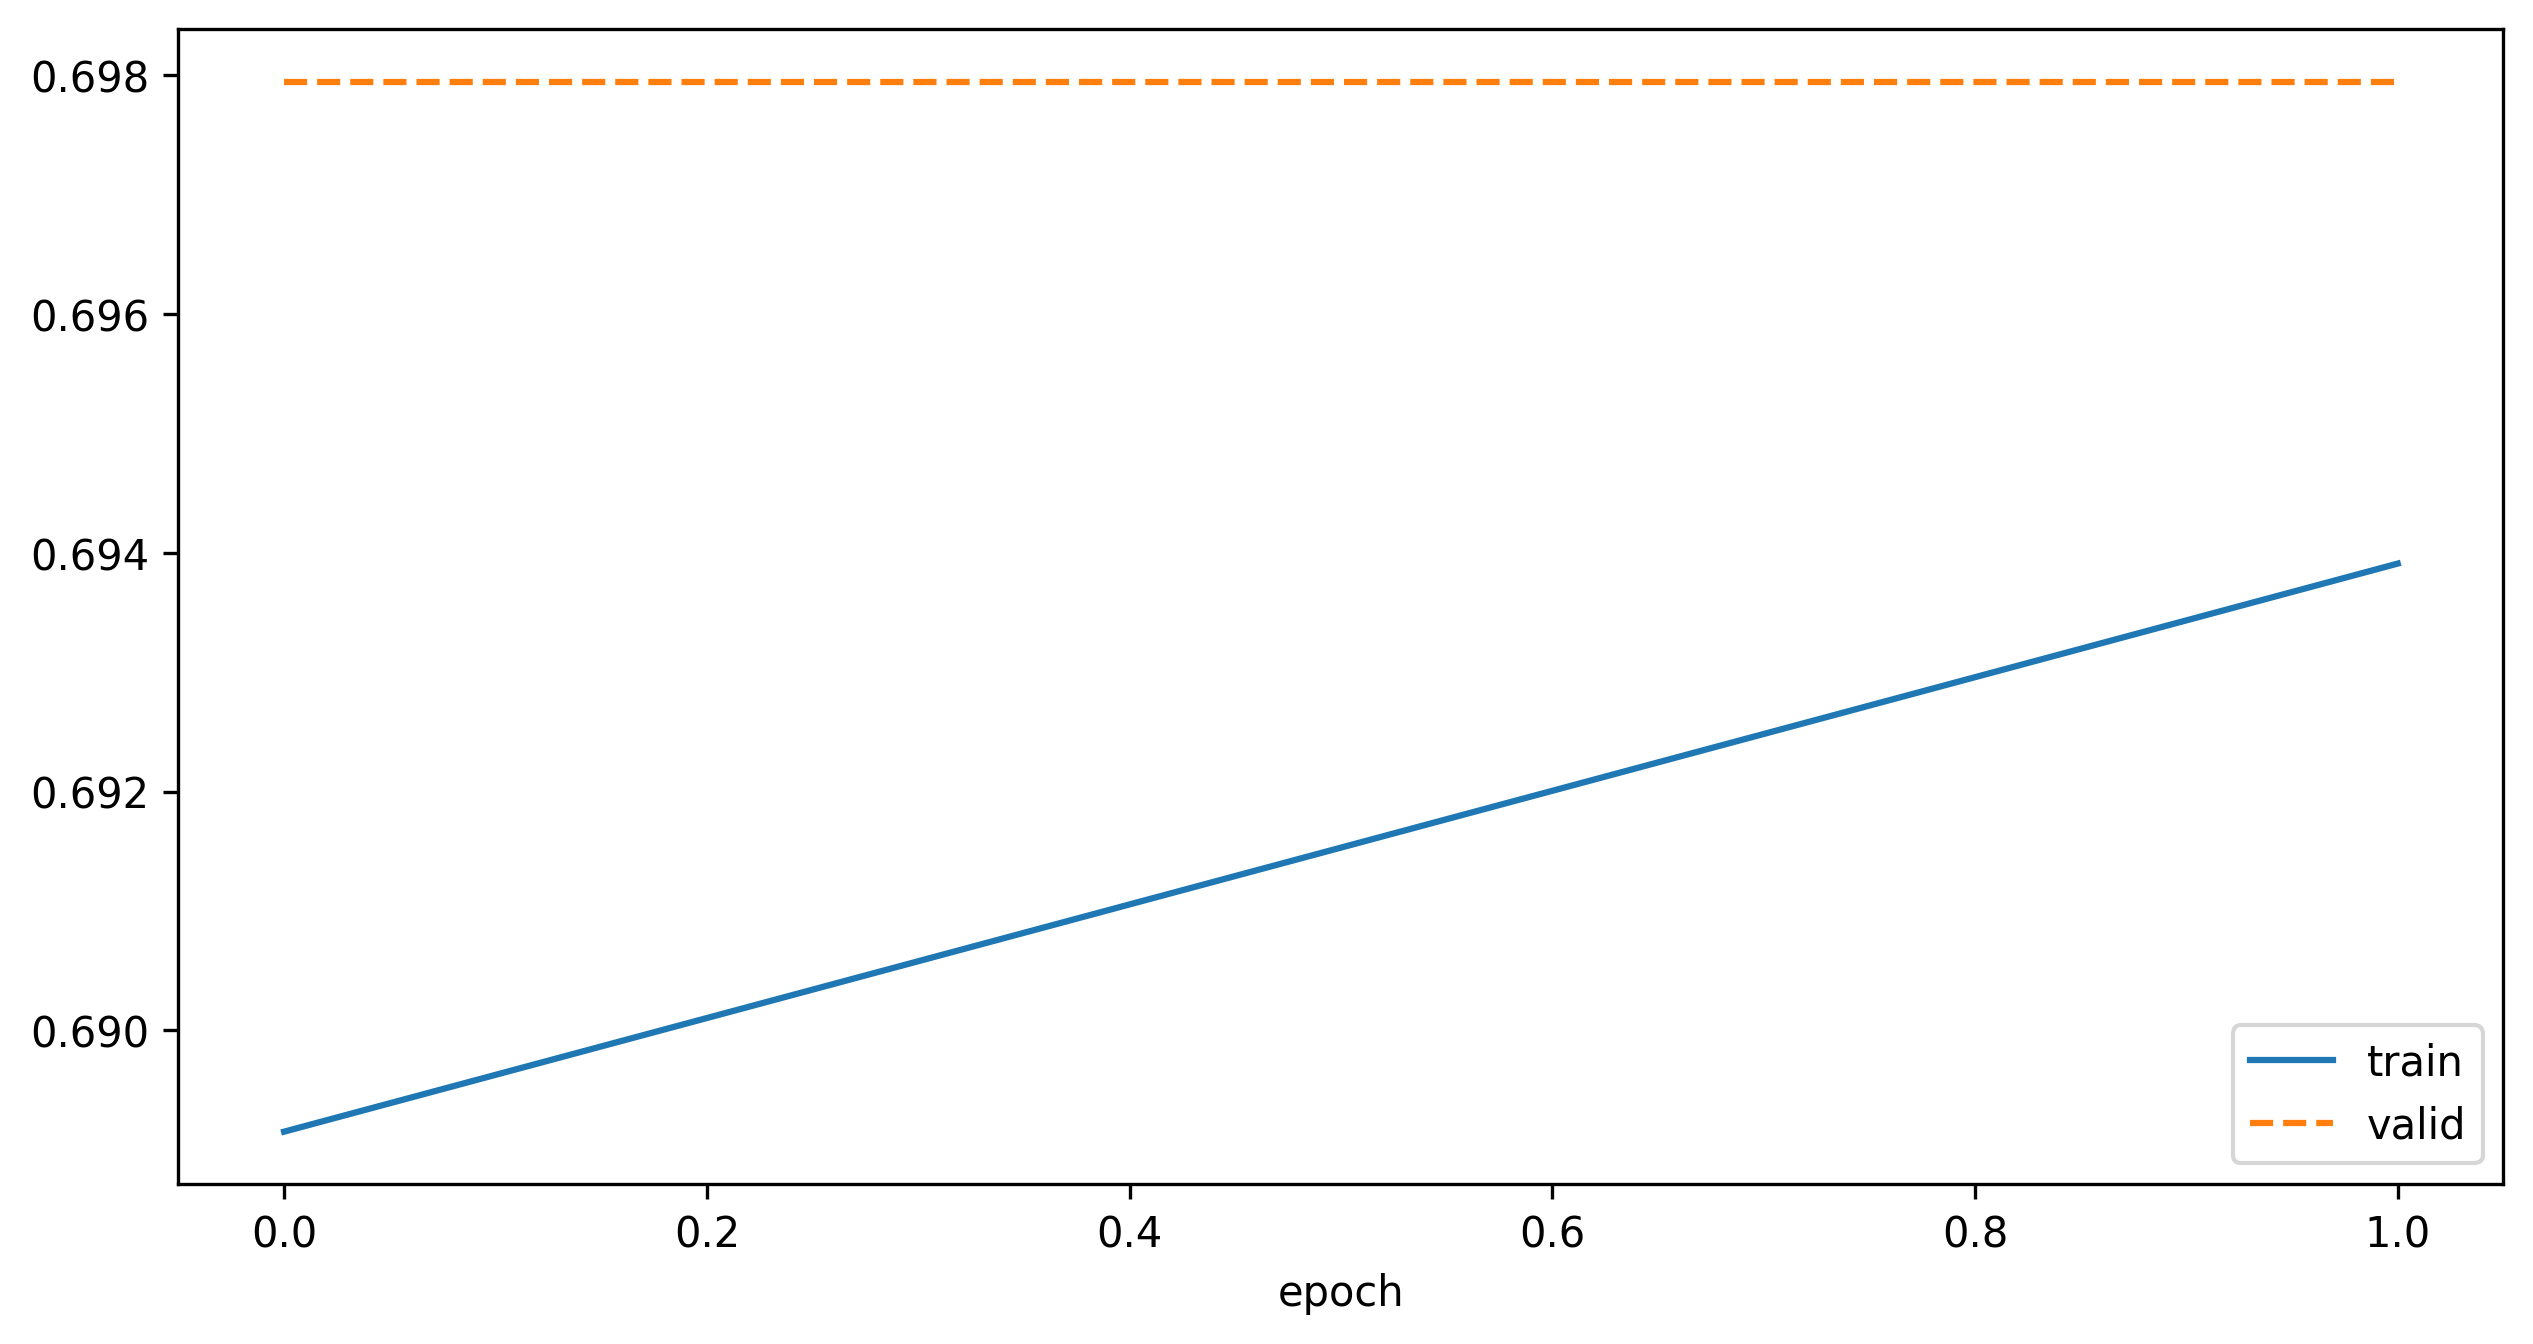

In [39]:
history = {
    'train/loss': [0.6891509493192037, 0.6939094463984171],
    'valid/loss': [0.697946031888326, 0.697946031888326],
    'valid/f1': [0.04855302080998519, 0.04855302080998519],
    'valid/Appeal_to_Values': [0.0, 0.0],
    'valid/Loaded_Language': [0.08980785296574771, 0.08980785296574771],
    'valid/Consequential_Oversimplification': [0.0, 0.0],
    'valid/Causal_Oversimplification': [0.0, 0.0],
    'valid/Questioning_the_Reputation': [0.3707482993197278, 0.3707482993197278],
    'valid/Straw_Man': [0.0, 0.0],
    'valid/Repetition': [0.0, 0.0],
    'valid/Guilt_by_Association': [0.0, 0.0],
    'valid/Appeal_to_Hypocrisy': [0.0, 0.0],
    'valid/Conversation_Killer': [0.0, 0.0],
    'valid/False_Dilemma-No_Choice': [0.30303030303030304, 0.30303030303030304],
    'valid/Whataboutism': [0.0, 0.0],
    'valid/Slogans': [0.0, 0.0],
    'valid/Obfuscation-Vagueness-Confusion': [0.05128205128205129, 0.05128205128205129],
    'valid/Name_Calling-Labeling': [0.14531590413943354, 0.14531590413943354],
    'valid/Flag_Waving': [0.0, 0.0],
    'valid/Doubt': [0.0, 0.0],
    'valid/Appeal_to_Fear-Prejudice': [0.0, 0.0],
    'valid/Exaggeration-Minimisation': [0.0, 0.0],
    'valid/Red_Herring': [0.0, 0.0],
    'valid/Appeal_to_Popularity': [0.0, 0.0],
    'valid/Appeal_to_Authority': [0.1568627450980392, 0.1568627450980392],
    'valid/Appeal_to_Time': [0.0, 0.0]
}


fig, ax = plt.subplots(1,1, figsize=(10,5), dpi=300)
ax.plot(history['train/loss'], linestyle='-', label='train')
ax.plot(history['valid/loss'], linestyle='--', label='valid')
ax.legend()
ax.set_xlabel("epoch")
plt.show()